# Intro to Scikit-learn

Especially for more complex algorithms, we do not want to have to code them all ourselves. Scikit-learn is a library based on the Python library of the same name, and contains many tools for training and testing models, preprocessing data, and tuning hyperparameters.  
  
Documentation can be found here:   
http://scikitlearnjl.readthedocs.io/en/latest/ (Julia)  
http://scikit-learn.org/stable/documentation.html (Python)

In [1]:
# Pkg.add("ScikitLearn")
# Pkg.update()
using ScikitLearn
using ScikitLearn.CrossValidation: train_test_split

In [2]:
# Pkg.add("RDatasets")
using RDatasets: dataset
iris = dataset("datasets", "iris");

INFO: Recompiling stale cache file /home/juser/.julia/lib/v0.6/RData.ji for module RData.


In [3]:
X = convert(Array, iris[[:SepalLength, :SepalWidth, :PetalLength, :PetalWidth]])
y = convert(Array, iris[:Species]);

In [4]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3);

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Fitting a Model

First, import and initialize a model of a specific algorithm type.

In [5]:
@sk_import linear_model: LogisticRegression;

In [6]:
model = LogisticRegression(fit_intercept=true)

PyObject LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

To train a model, call the fit! function.

In [7]:
fit!(model, X_train, y_train);

To test a model, use the predict function.

In [8]:
accuracy = sum(predict(model, X_test) .== y_test) / length(y_test)
println("accuracy: $accuracy")

accuracy: 0.9777777777777777


## Cross-Validation

k-fold cross-validation: at each iteration, we use $\frac{k-1}{k}$ of the dataset as training data, and $\frac{1}{k}$ as the test data. Once complete, we will have used every point as training data $k-1$ times and as test data once.

In [9]:
# Pkg.add("CSV")
using CSV

In [75]:
data = CSV.read("Dataset.csv", nullable=false);

In [52]:
m,n = size(data)

(3196, 37)

In [76]:
data = data[randperm(m),:];

In [77]:
X = convert(Array, data)[:,1:n-1];
y = convert(Array, data)[:,n];

In [79]:
y = convert(Array{Bool}, y);

In [80]:
@sk_import svm: SVC
using ScikitLearn.CrossValidation: cross_val_score, KFold

In [81]:
model = SVC(kernel="rbf", probability=true)

PyObject SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [82]:
fit!(model, X, y);

In [83]:
cross_val_score(model, X, y; cv=5)

5-element Array{Float64,1}:
 0.939063
 0.948438
 0.931142
 0.949922
 0.943574

## Hyperparameter Tuning

Hyperparameters are values about the structure of our algorithm that we decide - they are NOT learned when we fit a model. While algorithms such as ordinary least squares have no hyperparameters, more complex ones have many. As it is very difficult to calculate gradients with respect to hyperparameters, it is generally difficult to find optimal values.

In [16]:
# Pkg.add("PyPlot")
using PyPlot
using PyCall
using ScikitLearn.Utils: meshgrid
@sk_import datasets: (make_moons, make_circles, make_classification);
@sk_import preprocessing: StandardScaler;
@pyimport matplotlib.colors as mplc;

In [17]:
ds = make_moons(noise=0.3);

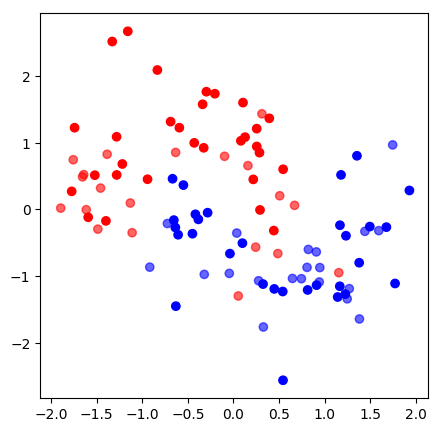

PyObject <matplotlib.collections.PathCollection object at 0x7f26741895d0>

In [18]:
h = 0.02
fig = figure(figsize=(5,5))

X, y = ds
X = fit_transform!(StandardScaler(), X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

cm = PyPlot.cm[:RdBu]
cm_bright = mplc.ListedColormap(["#FF0000", "#0000FF"])
ax = subplot(1, 1, 1)
ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, alpha=0.6)

In [19]:
@sk_import neighbors: KNeighborsClassifier;

Perform cross-validation using different hyperparameter settings

In [20]:
model1 = KNeighborsClassifier(n_neighbors=3)
model2 = KNeighborsClassifier(n_neighbors=9)

PyObject KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [21]:
mean(cross_val_score(model1, X, y; cv=5))

0.9400000000000001

In [22]:
mean(cross_val_score(model2, X, y; cv=5))

0.95

In [23]:
fit!(model1, X_train, y_train);
fit!(model2, X_train, y_train);

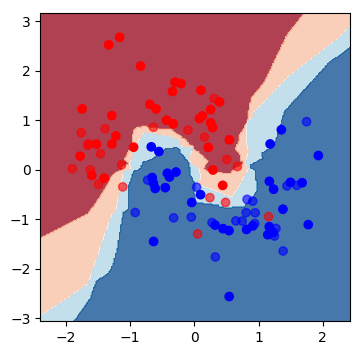

PyObject <matplotlib.collections.PathCollection object at 0x7f2674042910>

In [24]:
fig = figure(figsize=(4,4))
ax = subplot(1,1,1)
fit!(model1, X_train, y_train)
scor = score(model1, X_test, y_test)

x_min, x_max = minimum(X[:, 1]) - .5, maximum(X[:, 1]) + .5
y_min, y_max = minimum(X[:, 2]) - .5, maximum(X[:, 2]) + .5
xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max)

# Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, m_max]x[y_min, y_max].
Z = predict_proba(model1, hcat(xx[:], yy[:]))[:, 2]
Z = reshape(Z, size(xx)...)

ax[:contourf](xx, yy, Z, cmap=cm, alpha=.8)
ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, alpha=0.6)

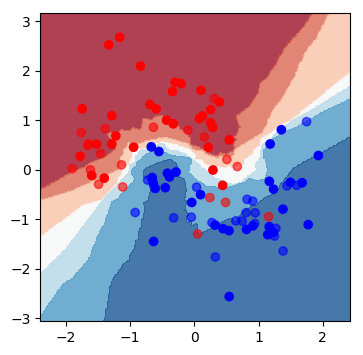

PyObject <matplotlib.collections.PathCollection object at 0x7f2673ceec50>

In [25]:
fig = figure(figsize=(4,4))
ax = subplot(1,1,1)
fit!(model2, X_train, y_train)
scor = score(model2, X_test, y_test)

x_min, x_max = minimum(X[:, 1]) - .5, maximum(X[:, 1]) + .5
y_min, y_max = minimum(X[:, 2]) - .5, maximum(X[:, 2]) + .5
xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max)

# Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, m_max]x[y_min, y_max].
Z = predict_proba(model2, hcat(xx[:], yy[:]))[:, 2]
Z = reshape(Z, size(xx)...)

ax[:contourf](xx, yy, Z, cmap=cm, alpha=.8)
ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, alpha=0.6)

In [26]:
using ScikitLearn.GridSearch: GridSearchCV

In [27]:
gridsearch = GridSearchCV(KNeighborsClassifier(), Dict(:n_neighbors => 1:11))
fit!(gridsearch, X, y)
gridsearch.best_params_

Dict{Symbol,Any} with 1 entry:
  :n_neighbors => 1

## Comparison of Algorithm Types

There are over 100 different model types in Scikit-learn - some of which will be covered in class, most of which will not. For your projects, we encourage you to try out many different algorithm types in order to find one that is best suited to the dataset you have chosen. Below, we illustrate some of the properties of different models in a 2-D space.  
  
Modified from: https://github.com/cstjean/ScikitLearn.jl/blob/master/examples/Classifier_Comparison_Julia.ipynb

In [28]:
@sk_import tree: DecisionTreeClassifier;
@sk_import ensemble: (RandomForestClassifier, AdaBoostClassifier);
@sk_import naive_bayes: GaussianNB;

In [29]:
names = ["RBF SVM", "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]

classifiers = [
    SVC(gamma=2, C=1), DecisionTreeClassifier(min_samples_split=2), RandomForestClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=30), GaussianNB()
]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
srand(42)
X += 2 * rand(size(X)...)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0), make_circles(noise=0.2, factor=0.5, random_state=1), linearly_separable];

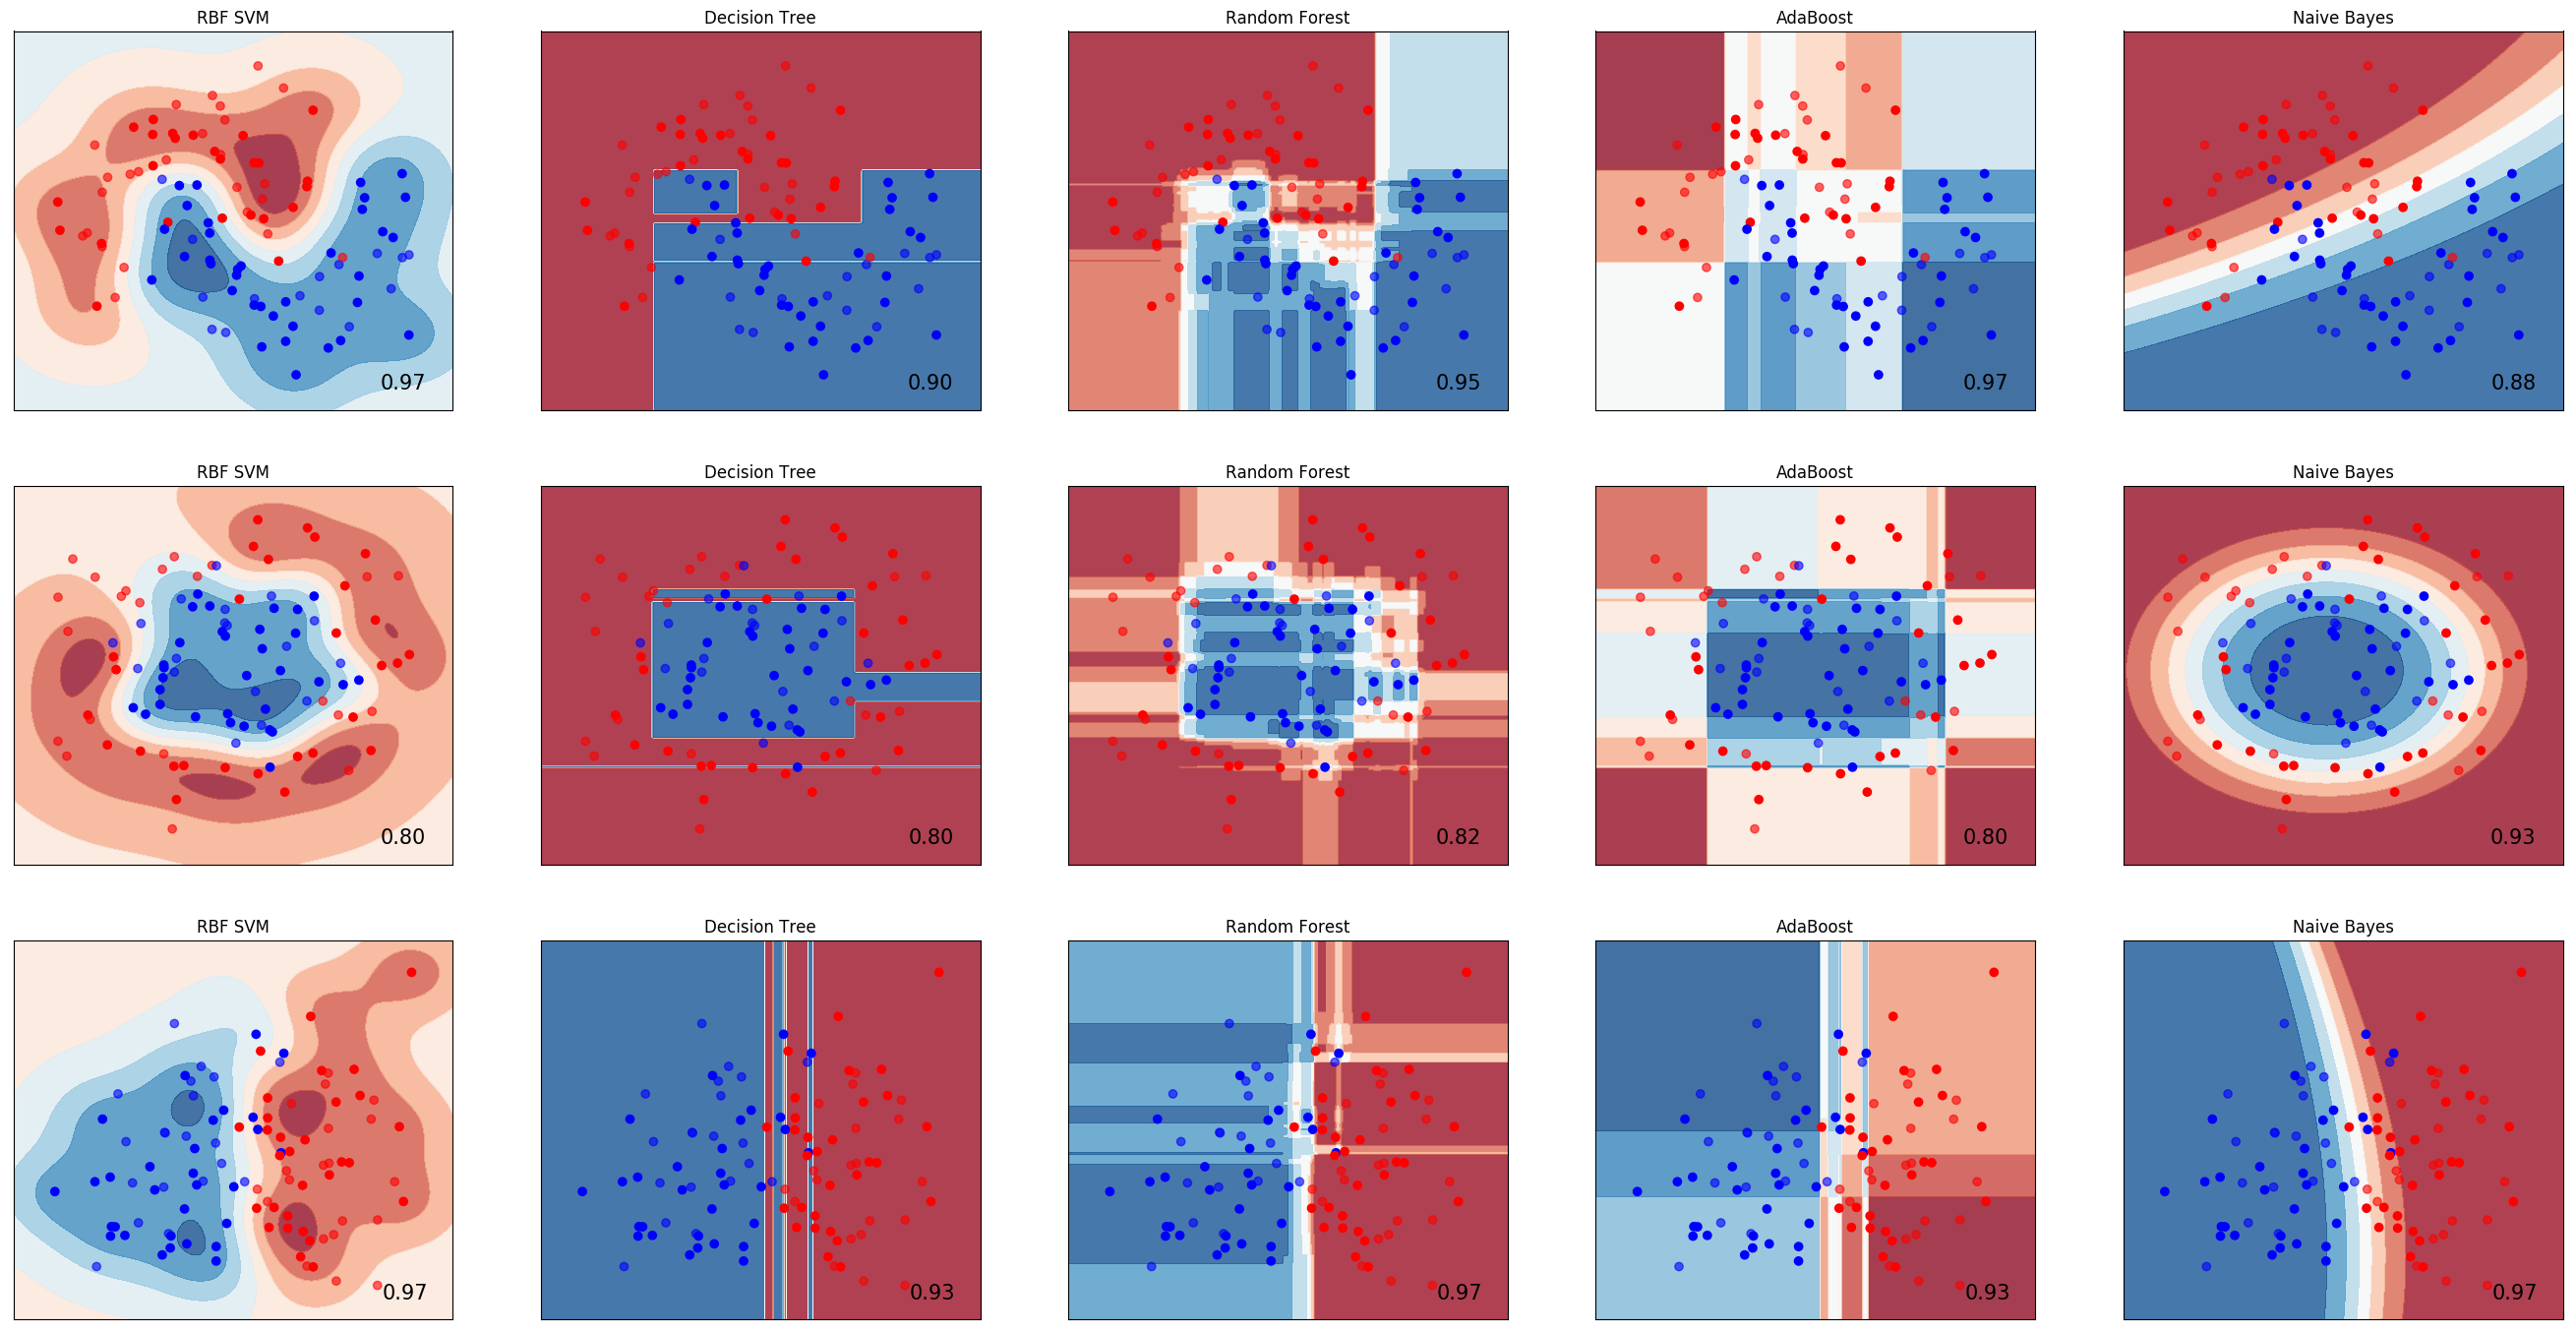

In [30]:
fig = figure(figsize=(27, 17))
i = 1
# iterate over datasets
for ds in datasets
    # preprocess dataset, split into training and test part
    X, y = ds
    X = fit_transform!(StandardScaler(), X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = minimum(X[:, 1]) - .5, maximum(X[:, 1]) + .5
    y_min, y_max = minimum(X[:, 2]) - .5, maximum(X[:, 2]) + .5
    xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max)

    # iterate over classifiers
    for (name, clf) in zip(names, classifiers)
        ax = subplot(length(datasets), length(classifiers), i)
        fit!(clf, X_train, y_train)
        scor = score(clf, X_test, y_test)

        try 
            Z = decision_function(clf, hcat(xx[:], yy[:]))
        catch
            Z = predict_proba(clf, hcat(xx[:], yy[:]))[:, 2]
        end

        Z = reshape(Z, size(xx)...)
        ax[:contourf](xx, yy, Z, cmap=cm, alpha=.8)
        ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
        ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, alpha=0.6)

        ax[:set_xlim](minimum(xx), maximum(xx))
        ax[:set_ylim](minimum(yy), maximum(yy))
        ax[:set_xticks](())
        ax[:set_yticks](())
        ax[:set_title](name)

        ax[:text](maximum(xx) - .3, minimum(yy) + .3, @sprintf("%.2f", scor), size=15, horizontalalignment="right")
        i += 1
    end
end
fig[:subplots_adjust](left=.02, right=.98)